In [87]:
import argparse
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
# %matplotlib inline
%matplotlib inline

In [88]:
def net_shape(net):
    return jax.tree_map(lambda x: x.shape, net)

In [89]:
from qdax.core.rl_es_parts.es_setup import setup_es

In [90]:
default_args = {
    'env_name': 'halfcheetah_uni',
    'episode_length': 1000,
    'evals': 1000000,
    'seed': 42,
    'policy_hidden_layer_sizes': 128,
    'critic_hidden_layer_sizes': 128,
    'deterministic': True,
    'num_init_cvt_samples': 50000,
    'num_centroids': 1024,
    'min_bd': 0.0,
    'max_bd': 1.0,
    'es': 'canonical',
    'pop': 100,
    'es_sigma': 1,
    'sample_mirror': False,
    'sample_rank_norm': False,
    'adam_optimizer': False,
    'learning_rate': 1, 
    'l2_coefficient': 0.02,
    'nses_emitter': False,
    'novelty_nearest_neighbors': 10,
    'rl': False,
    'testrl': False,
    'carlies': False,
    'elastic_pull': 0,
    'discount': 0.99,
    'actor_injection': True,
    'injection_clip': False,
    'nb_injections': 1,
    'critic_training': 1000,
    'pg_training': 1000,
    'actor_lr': 3e-4,
    'critic_lr': 3e-4,
    'es_target': False,
    'surrogate': False,
    'surrogate_batch': 1024,
    'surrogate_omega': 0.6,
    'spearman': False,
    'output': '',
    'plot': False,
    'wandb': '',
    'tag': '',
    'jobid': '',
    'log_period': 1,
    'debug': True,
    'logall': False
}

# make like an argparse result
args = argparse.Namespace(**default_args)

if args.carlies or args.testrl or args.surrogate or args.spearman or args.actor_injection:
    args.rl = True
    # args.actor_injection = False

if args.es_target and not args.rl:
    raise ValueError("ES target requires RL")

if args.injection_clip and not args.actor_injection:
    raise ValueError("Injection clip requires actor injection")

if args.debug:
    # Cheap ES to debug
    debug_values = {
        # 'env_name': 'walker2d_uni',
        'episode_length': 100,
        "pop": 10,
        'evals': 100,
        'policy_hidden_layer_sizes': 16,
        'critic_hidden_layer_sizes': 16,
        "output": "debug",
        'surrogate_batch': 10,
    }
    for k, v in debug_values.items():
        setattr(args, k, v)

log_period = args.log_period
args.num_gens = args.evals // args.pop
# num_loops = int(args.num_gens / log_period)

args.policy_hidden_layer_sizes = (args.policy_hidden_layer_sizes, args.policy_hidden_layer_sizes)
args.critic_hidden_layer_sizes = (args.critic_hidden_layer_sizes, args.critic_hidden_layer_sizes)

algos = {
    'open': 'OpenAI',
    'openai': 'OpenAI',
    'canonical': 'Canonical',
    'cmaes': 'CMAES',
    'random': 'Random',
}
args.algo = algos[args.es]

suffix = ''
if args.rl:
    suffix = '-RL'
if args.carlies:
    suffix = '-CARLIES'
if args.testrl:
    suffix = '-TestRL'
if args.surrogate:
    suffix = '-Surrogate'
if args.spearman:
    suffix = '-Spearman'
args.algo += f"{suffix}"


if args.actor_injection:
    args.algo += "-AI"

In [91]:
args.algo

'Canonical-RL-AI'

In [92]:
EM = setup_es(args)

Imported modules


KeyboardInterrupt: 

In [ ]:
es = EM.es
env = EM.env
policy_network = EM.policy_network
emitter = EM.emitter
emitter_state = EM.emitter_state
repertoire = EM.repertoire
random_key = EM.random_key
wandb_run  = EM. wandb_run
scoring_fn = EM.scoring_fn

In [ ]:
def scores(fitnesses, descriptors) -> jnp.ndarray:
    return fitnesses

In [ ]:
emitter.es_emitter

In [ ]:
offspring = emitter_state.es_state.offspring
# net_shape(offspring)

In [ ]:
# remove 1 dim
offspring = jax.tree_map(lambda x: x.squeeze(0), offspring)
# net_shape(offspring)

In [ ]:
actor = emitter_state.rl_state.actor_params
# net_shape(actor)

In [ ]:
actor_genes = emitter.es_emitter.flatten(actor)
offspring_genes = emitter.es_emitter.flatten(offspring)

# check if equal
jnp.allclose(actor_genes, offspring_genes)

DeviceArray(True, dtype=bool)

In [ ]:


# net_shape(interpolated)

In [102]:
def compute_canonical_update(parent, sigma, sample_number, scoring_fn, unflatten_fn, flatten_fn):
    # add 1dim to parent
    parent = jax.tree_map(lambda x: jnp.expand_dims(x, axis=0), parent)
    
    # print(f"Parent, {net_shape(parent)}")
    mu = sample_number // 2
    # sample points as gaussian noise
    random_key = jax.random.PRNGKey(42)
    random_key, subkey = jax.random.split(random_key)

    sample_noise = jax.tree_map(
        lambda x: jax.random.normal(
            key=subkey,
            shape=jnp.repeat(x, sample_number, axis=0).shape,
        ),
        parent,
    )

    networks = jax.tree_map(
        lambda x: jnp.repeat(x, sample_number, axis=0),
        parent,
    )
    networks = jax.tree_map(
        lambda mean, noise: mean + sigma * noise,
        networks,
        sample_noise,
    )

    # print(f"networks, {net_shape(networks)}")

    # compute fitness
    random_key, subkey = jax.random.split(random_key)
    fitnesses, _, _, _ = scoring_fn(networks, subkey)
    
    # compute update
    scores = fitnesses

    ranking_indices = jnp.argsort(scores, axis=0) 
    ranks = jnp.argsort(ranking_indices, axis=0) 
    ranks = sample_number - ranks # Inverting the ranks
    
    weights = jnp.where(ranks <= mu, jnp.log(mu+0.5) - jnp.log(ranks), 0) 
    weights /= jnp.sum(weights) # Normalizing the weights

    # Reshaping rank to match shape of genotype_noise
    weights = jax.tree_map(
        lambda x: jnp.reshape(
            jnp.repeat(weights.ravel(), x[0].ravel().shape[0], axis=0), x.shape
        ),
        sample_noise,
    )

    # Computing the update
    # Noise is multiplied by rank
    gradient = jax.tree_map(
        lambda noise, rank: jnp.multiply(noise, rank),
        sample_noise,
        weights,
    )
    # Noise is summed over the sample dimension and multiplied by sigma
    gradient = jax.tree_map(
        lambda x: jnp.reshape(x, (sample_number, -1)),
        gradient,
    )
    gradient = jax.tree_map(
        lambda g, p: jnp.reshape(
            jnp.sum(g, axis=0) * sigma,
            p.shape,
        ),
        gradient,
        parent,
    )

    # remove one dimension
    gradient = jax.tree_map(lambda x: x.squeeze(0), gradient)

    # flatten
    gradient = flatten_fn(gradient)

    return gradient
    

unflatten_fn = jax.vmap(emitter.es_emitter.unflatten)
flatten_fn = emitter.es_emitter.flatten
scoring_fn = EM.scoring_fn

update = compute_canonical_update(offspring, 1, 10, scoring_fn, unflatten_fn, flatten_fn)
print(f"update, {net_shape(update)}")

update, (678,)


In [109]:
# project onto offspring-actor vector
actor_genes = emitter.es_emitter.flatten(actor)
actor_genes *= 1.1 # make sure it's not equal

offspring_genes = emitter.es_emitter.flatten(offspring)
vector = actor_genes - offspring_genes

update_vec = emitter.es_emitter.flatten(update)
update_vec = jnp.dot(update_vec, vector) 
update_vec 

DeviceArray(0.2227022, dtype=float32)

In [119]:
def project(update_vec, vector):
    update_vec = jnp.dot(update_vec, vector)
    # print(f"update_vec, {net_shape(update_vec)}")
    return update_vec

def stability_interpolate(offspring, actor, n_points, sample_size, sigma, EM):
    unflatten_fn = jax.vmap(EM.emitter.es_emitter.unflatten)
    flatten_fn = EM.emitter.es_emitter.flatten
    scoring_fn = EM.scoring_fn

    actor_genes = EM.emitter.es_emitter.flatten(actor)
    offspring_genes = EM.emitter.es_emitter.flatten(offspring)

    vector = actor_genes - offspring_genes

    # Interpolate from -1 to 2
    alphas = jnp.linspace(-1, 2, n_points)
    interpolated = jnp.outer(alphas, vector) + offspring_genes

    # print first component of each network
    # print("Interpolated", interpolated[:, 0])

    networks = unflatten_fn(interpolated)

    # print(f"networks, {net_shape(networks)}")

    # vmap compute_canonical_update over networks
    update = jax.vmap(
        lambda network: compute_canonical_update(
            network, sigma, sample_size, scoring_fn, unflatten_fn, flatten_fn
        ),
        in_axes=0,
    )(networks)

    # print(f"update, {net_shape(update)}")

    # project onto offspring-actor vector
    update_comp = jax.vmap(project, in_axes=(0, None))(update, vector)
    return alphas, update_comp
    
fake_actor = jax.tree_map(lambda x: x * 1.1, actor)
alphas, update_comp = stability_interpolate(offspring, fake_actor, 10, 10, 1, EM)

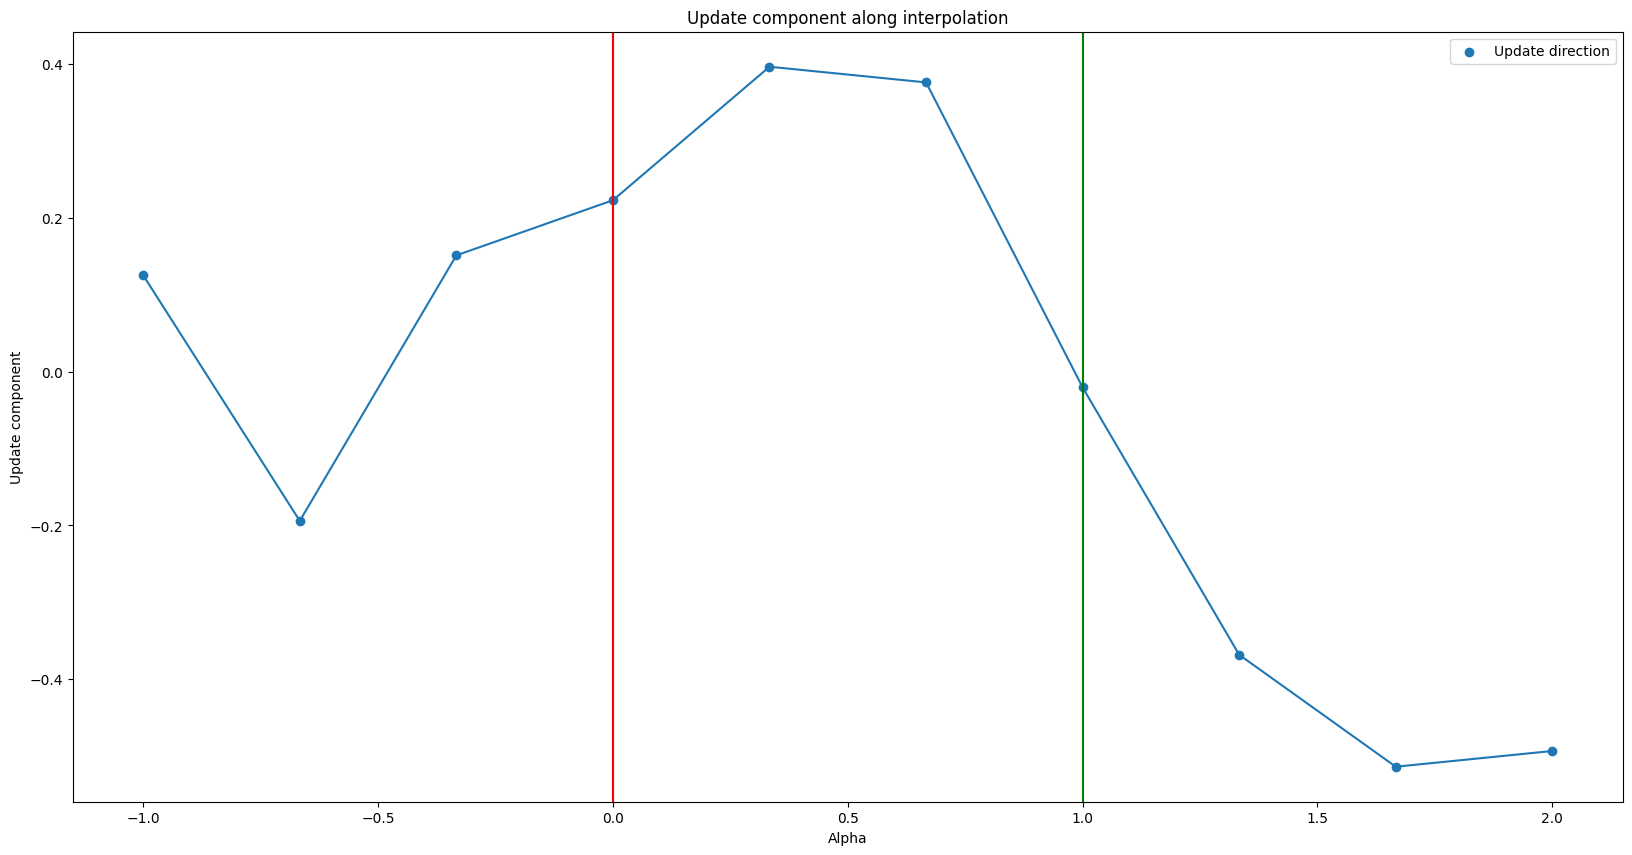

In [121]:
plt.figure(figsize=(20, 10))
plt.plot(alphas, update_comp)
plt.scatter(alphas, update_comp, label="Update direction")
# Add vertical line at 0 for offspring
plt.axvline(x=0, color="red")
plt.axvline(x=1, color="green")
plt.legend()
# Axis
plt.xlabel("Alpha")
plt.ylabel("Update component")
plt.title("Update component along interpolation")
plt.show()